# 1. Import Libraries

In [14]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import requests
import gc
from io import BytesIO
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2
import wandb
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB3, DenseNet169, Xception, ConvNeXtBase
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

SEED = 244
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load Dataset

### 2.1 Define GitHub Repo & Folder Path

In [2]:
GITHUB_REPO = "prattapong/Commercial-Airplane-Model-Image-Classification"
GITHUB_FOLDER = "images"
GITHUB_API_URL = f"https://api.github.com/repos/{GITHUB_REPO}/contents/{GITHUB_FOLDER}"

### 2.2 Fetch Image URLs and Load Image

In [3]:
original_sizes = []
color_counts = {"RGB": 0, "Grayscale": 0}

In [4]:
# Fetch Image URLs Automatically
def get_image_urls():
    response = requests.get(GITHUB_API_URL)
    if response.status_code != 200:
        raise Exception(f"Error fetching images: {response.json()}")

    image_urls = {}
    for folder in response.json():
        if folder["type"] == "dir":  # Ensure it's a folder (A350, B787, A320)
            class_name = folder["name"]
            image_urls[class_name] = []
            folder_url = folder["url"]

            # Fetch image files in each class folder
            folder_response = requests.get(folder_url)
            if folder_response.status_code == 200:
                for file in folder_response.json():
                    if file["name"].lower().endswith((".jpg", ".jpeg", ".png")):
                        image_urls[class_name].append(file["download_url"])

    return image_urls

# Load Images Function (Now storing original info before resizing)
def load_images(image_urls):
    IMG_SIZE = (224, 224)  # Resize all images to 224x224
    X, y = [], []

    total_images = sum(len(urls) for urls in image_urls.values())  # Total number of images
    progress_bar = tqdm(total=total_images, desc="Loading Images", unit="img")

    for label, urls in image_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content))

                # Store original size and color type
                original_sizes.append(img.size)  # (width, height)
                if img.mode == "L":
                    color_counts["Grayscale"] += 1
                else:
                    color_counts["RGB"] += 1

                # Convert to RGB and resize
                img = img.convert("RGB").resize(IMG_SIZE)
                X.append(np.array(img) / 255.0)  # Normalize
                y.append(label)

            except Exception as e:
                print(f"Error loading {url}: {e}")

            progress_bar.update(1)  # Update progress bar

    progress_bar.close()
    return np.array(X), pd.Categorical(y).codes

In [5]:
image_urls = get_image_urls()
X, y = load_images(image_urls)  # Load images first

Loading Images: 100%|██████████| 605/605 [02:25<00:00,  4.15img/s]


# 3. EDA

In [6]:
# Function to Display Original Image Size Distribution as DataFrame
def display_original_image_sizes(original_sizes):
    size_counts = Counter(tuple(size) for size in original_sizes)
    size_df = pd.DataFrame(size_counts.items(), columns=["Image Size", "Frequency"])
    size_df = size_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)
    size_df["Percentage"] = (size_df["Frequency"] / size_df["Frequency"].sum()) * 100
    print(size_df)

# Function to Show Color vs Grayscale Distribution
def plot_color_distribution(color_counts):
    plt.figure(figsize=(6, 4))
    plt.pie(color_counts.values(), labels=color_counts.keys(), autopct="%1.1f%%", colors=["lightblue", "gray"])
    plt.title("Color vs. Grayscale Images (Before Processing)")
    plt.show()

# Function to Show Class Distribution After Processing
def plot_class_distribution(y):
    class_counts = Counter(y)
    class_labels = sorted(class_counts.keys())  # Ensure ordered class names

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution in Dataset")
    plt.xticks(range(len(class_labels)), class_labels, rotation=45)
    plt.show()


# Function to Show Sample Images After Processing
def show_sample_images(X, y, class_labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    sampled_indices = np.random.choice(len(X), num_images, replace=False)

    for i, idx in enumerate(sampled_indices):
        axes[i].imshow(X[idx])
        axes[i].axis("off")
        axes[i].set_title(f"Class: {class_labels[y[idx]]}")

    plt.show()

# Perform Full EDA
def perform_eda(X, y, class_labels):
    print(f"Total images after processing: {len(X)}")
    print(f"Processed image shape: {X[0].shape}")  # Should be (224, 224, 3)

    display_original_image_sizes(original_sizes)
    plot_color_distribution(color_counts)

    plot_class_distribution(y)
    show_sample_images(X, y, class_labels)

Total images after processing: 605
Processed image shape: (224, 224, 3)
       Image Size  Frequency  Percentage
0     (1280, 872)         50    8.264463
1    (1920, 1299)         40    6.611570
2      (400, 225)         38    6.280992
3    (1920, 1099)         34    5.619835
4     (1200, 819)         33    5.454545
..            ...        ...         ...
188  (5182, 3293)          1    0.165289
189  (5440, 3060)          1    0.165289
190  (4581, 2577)          1    0.165289
191  (4966, 2794)          1    0.165289
192   (1024, 768)          1    0.165289

[193 rows x 3 columns]


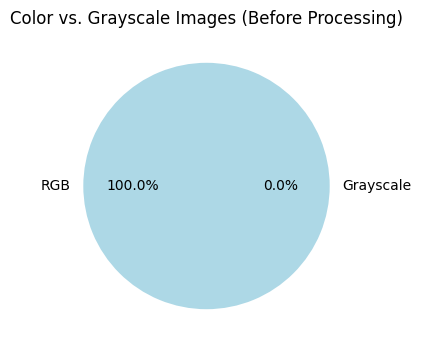

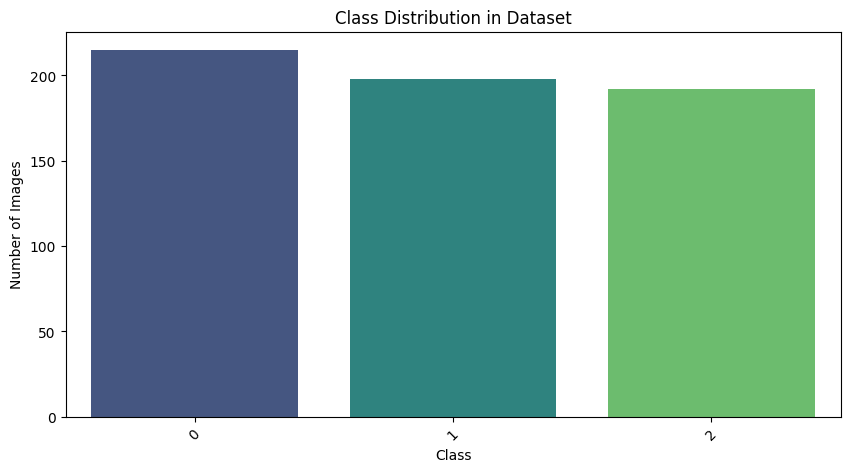

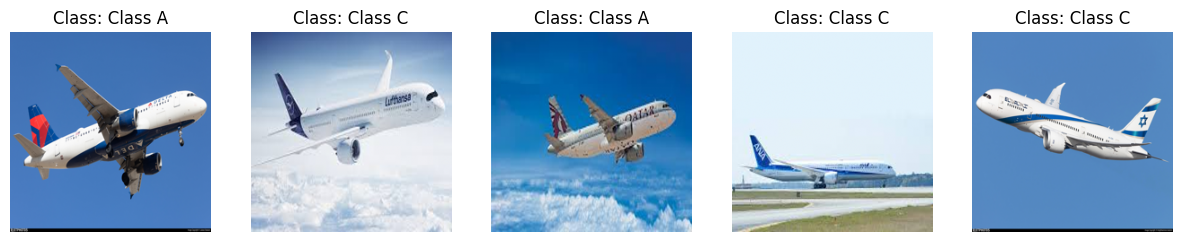

In [7]:
class_labels = ["Class A", "Class B", "Class C"]
perform_eda(X, y, class_labels)

# 3. Data-preprocessing

In [8]:
def preprocess_edges(X):
    edge_images = []

    for img in X:
        # Convert image to grayscale
        gray_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray_img, 1, 20)

        # Convert back to RGB format to maintain consistency
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)

        # Normalize to [0, 1]
        edge_images.append(edges_rgb / 255.0)

    return np.array(edge_images)

In [9]:
X_edge = preprocess_edges(X)

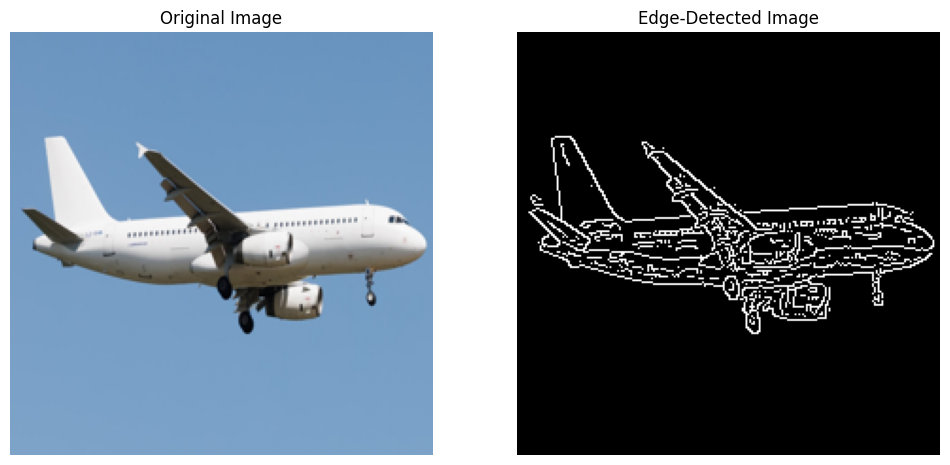

In [10]:
def plot_original_vs_edge(X, X_edge, index):
    # Plot original image (X[0]) and edge-detected image (X_edge[0])
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axes[0].imshow(X[index])
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    # Edge-Detected Image
    axes[1].imshow(X_edge[index])
    axes[1].axis("off")
    axes[1].set_title("Edge-Detected Image")

    plt.show()

# Assuming you already have X (original images) and X_edge (edge-detected images)
plot_original_vs_edge(X, preprocess_edges(X), index = 210)

In [11]:
def augment_data(X_train):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    datagen.fit(X_train)

    return datagen

# 4. Train model

### 4.1 List 5 pre-trained models

In [12]:
MODELS = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "DenseNet169": DenseNet169,
    "Xception": Xception,
    "ConvNeXtBase": ConvNeXtBase
}

### 4.2 WandB

In [15]:
# Initialize WandB
def init_wandb(project_name="commercial-aircraft-model-classification", config=None):
    wandb.init(project=project_name, config=config)

def train_and_evaluate_model_with_wandb(model_name, X, y, batch_size, epochs, learning_rate, dropout_rate, early_stopping_rounds,num_unfreezed_layer=0):
    print(f'*** Training {model_name} with WandB ***')
    print(f'- Batch Size: {batch_size}')
    print(f'- LR: {learning_rate}')
    print(f'- Dropout: {dropout_rate}')
    print(f'- Last "{num_unfreezed_layer}" layers unfreezed\n')

    # Hyperparameters to log with WandB
    config = {
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "dropout_rate": dropout_rate,
        "num_unfreezed_layer": num_unfreezed_layer
    }

    # Initialize WandB for logging
    init_wandb(project_name="commercial-aircraft-model-classification",
               config=config)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )

    # Define Input Layer
    input_tensor = tf.keras.Input(shape=(224, 224, 3))

    # Load Pretrained Model
    base_model = MODELS[model_name](weights="imagenet", include_top=False, input_tensor=input_tensor)

    # Unfreeze Layers If Needed
    if num_unfreezed_layer == 0:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers[-num_unfreezed_layer:]:
            layer.trainable = True

    # Add Custom Classification Head
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    output_layer = tf.keras.layers.Dense(len(np.unique(y)), activation="softmax")(x)

    # Build Model
    model = tf.keras.Model(inputs=input_tensor, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # Data Augmentation
    datagen = augment_data(X_train)

    # Model Checkpointing (Save best model)
    model_path = f'best_{model_name}.keras'  # Use .keras format
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train Model with WandB logging for each epoch
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_rounds, restore_best_weights=True, verbose=1)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_test, y_test),
            epochs=1,  # Train one epoch at a time
            verbose=1,
            callbacks=[checkpoint]
        )

        # Log metrics to WandB after each epoch
        wandb.log({
            "epoch": epoch+1,
            "train_loss": history.history['loss'][-1],
            "train_accuracy": history.history['accuracy'][-1],
            "val_loss": history.history['val_loss'][-1],
            "val_accuracy": history.history['val_accuracy'][-1]
        })

    # Load Best Model
    custom_objects = get_custom_objects() if model_name == "ConvNeXtBase" else None
    best_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

    # Evaluate on Test Data
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")

    # Log test accuracy to WandB
    wandb.log({"test_accuracy": test_accuracy})

    # Clear session and collect garbage to free memory
    K.clear_session()
    gc.collect()

    return model_name, test_accuracy, history

In [ ]:
# Set hyperparameters manually
model_name = "ResNet50"  # Choose from [ResNet50,VGG16,DenseNet169,Xception,ConvNeXtBase]
batch_size = 8
epochs = 100
learning_rate = 0.001 # Between 0.00001 - 0.01
dropout_rate = 0.2 # Between 0.1 - 0.5
num_unfreezed_layer = 10 # Greater or equal to 0

# Train and evaluate model with WandB logging
early_stopping_rounds = epochs/10
train_and_evaluate_model_with_wandb(
    model_name=model_name,
    X=X,
    y=y,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    early_stopping_rounds=early_stopping_rounds,
    num_unfreezed_layer=num_unfreezed_layer
)

*** Training ResNet50 with WandB ***
- Batch Size: 8
- LR: 0.001
- Dropout: 0.2
- Last "10" layers unfreezed



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 6620422008 (6620422008-nida-business-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.3835 - loss: 1.7211
Epoch 1: val_accuracy improved from -inf to 0.35537, saving model to best_ResNet50.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 125s 954ms/step - accuracy: 0.3835 - loss: 1.7173 - val_accuracy: 0.3554 - val_loss: 6.0889
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4324 - loss: 1.0650
Epoch 1: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.4319 - loss: 1.0653 - val_accuracy: 0.3554 - val_loss: 1.1487
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3459 - loss: 1.1027
Epoch 1: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.3466 - loss: 1.1024 - val_accuracy: 0.3554 - val_loss: 1.2824
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3864 - loss: 1.0938
Epoch 1: val_accuracy did not improve from 0.35537
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.38

# 5. Show result of a sample

In [ ]:
def compute_gradcam(model, img_array, layer_name):
    """
    Computes Grad-CAM heatmap for a given image and model.

    Parameters:
    - model: Trained Keras model
    - img_array: Preprocessed image array with shape (1, height, width, channels)
    - layer_name: The name of the convolutional layer to extract gradients from

    Returns:
    - heatmap: Grad-CAM heatmap (numpy array)
    """
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Parameters:
    - img: Original image
    - heatmap: Grad-CAM heatmap
    - alpha: Transparency factor (default=0.5)

    Returns:
    - Superimposed image with heatmap
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

def show_prediction_with_gradcam(model, X, y, index, class_labels, layer_name="convnext_base_stage4_block2_layer_scale"):
    """
    Displays an image with the model's prediction, actual label, and Grad-CAM visualization.

    Parameters:
    - model: Trained Keras model
    - X: NumPy array of images
    - y: NumPy array of actual labels
    - index: Index of the image to display
    - class_labels: List of class names corresponding to label indices
    - layer_name: Name of the convolutional layer to compute Grad-CAM from (default: last ConvNeXt block)
    """
    sample_image = np.array(X[index])
    sample_input = np.expand_dims(sample_image, axis=0)

    # Predict
    predictions = model.predict(sample_input)
    predicted_class = np.argmax(predictions)
    actual_class = y[index]

    predicted_label = class_labels[predicted_class]
    actual_label = class_labels[actual_class]

    # Compute Grad-CAM
    heatmap = compute_gradcam(model, sample_input, layer_name)
    superimposed_img = overlay_heatmap((sample_image * 255).astype(np.uint8), heatmap)

    # Display Results
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axes[0].imshow(sample_image)
    axes[0].axis("off")
    axes[0].set_title(f"Original Image\nActual: {actual_label}\nPredicted: {predicted_label}", fontsize=12, color="blue")

    # Grad-CAM Overlay
    axes[1].imshow(superimposed_img)
    axes[1].axis("off")
    axes[1].set_title("Grad-CAM Visualization", fontsize=12, color="red")

    plt.show()

In [ ]:
class_labels = ["Airbus A320", "Airbus A350", "Boeing 787"]
# best_model = tf.keras.models.load_model("best_DenseNet169.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'best_DenseNet169.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
for i in [0,10,402,405,500, 600]:
    show_prediction(best_model, X, y, index=i, class_labels=class_labels)

AttributeError: 'list' object has no attribute 'predict'

In [ ]:
best_model

[('DenseNet169',
  0.6363636255264282,
  <keras.src.callbacks.history.History at 0x78474e749150>),
 ('Xception',
  0.4958677589893341,
  <keras.src.callbacks.history.History at 0x784605569ed0>),
 ('ConvNeXtBase',
  0.4628099203109741,
  <keras.src.callbacks.history.History at 0x78460436d1d0>),
 ('ResNet50',
  0.40495866537094116,
  <keras.src.callbacks.history.History at 0x7847c8233890>),
 ('EfficientNetB3',
  0.35537189245224,
  <keras.src.callbacks.history.History at 0x7847b41251d0>)]